In [2]:
import pandas as pd

train_df = pd.read_csv("./data/rainfall_train.csv")
test_df = pd.read_csv("./data/rainfall_test.csv")

train_df = train_df.drop(columns=['Unnamed: 0', 'rainfall_train.fc_year', 'rainfall_train.fc_month',
       'rainfall_train.fc_day', 'rainfall_train.fc_hour'])
test_df = test_df.drop(columns=['Unnamed: 0', 'rainfall_test.fc_year', 'rainfall_test.fc_month',
       'rainfall_test.fc_day', 'rainfall_test.fc_hour'])

train_df = train_df[train_df["rainfall_train.class_interval"] != -999]

In [3]:
# 각 계급 별 확률로 변경
# v00 = 100 - v01, v01 = v01 - v02 .. v08 = v09 - v08
for i in range(9):
    col = "rainfall_train.v0{}"
    train_df[col.format(i)]  = train_df[col.format(i)] - train_df[col.format(i+1)] if i != 0 else 100 - train_df[col.format(i+1)]

**"rainfall_train.v09" 값 추정**

In [4]:
nineth = pd.Series()
nineth["all"] = train_df[train_df["rainfall_train.class_interval"] == 9]["rainfall_train.vv"].mean()
nineth["A"] = train_df[(train_df["rainfall_train.class_interval"] == 9) & (train_df["rainfall_train.ef_year"] == "A")]["rainfall_train.vv"].median()
nineth["B"] = train_df[(train_df["rainfall_train.class_interval"] == 9) & (train_df["rainfall_train.ef_year"] == "B")]["rainfall_train.vv"].median()
nineth["C"] = train_df[(train_df["rainfall_train.class_interval"] == 9) & (train_df["rainfall_train.ef_year"] == "C")]["rainfall_train.vv"].median()

In [5]:
nineth

all    47.41138
A      40.90000
B      40.80000
C      40.90000
dtype: float64

### 예측 강수량 설정

In [5]:
median_list= [0,0.15,0.35,0.75,1.5,3.5,7.5,15,25,40]
train_df["v_median"] = train_df[["rainfall_train.v0{}".format(i) for i in range(10)]].apply(lambda x:sum([ median_list[idx]* (e/100) for idx,e in enumerate(x)]), axis=1)

###  V_median과 강수 무강수 클래스와의 관계



<Figure size 2000x800 with 0 Axes>

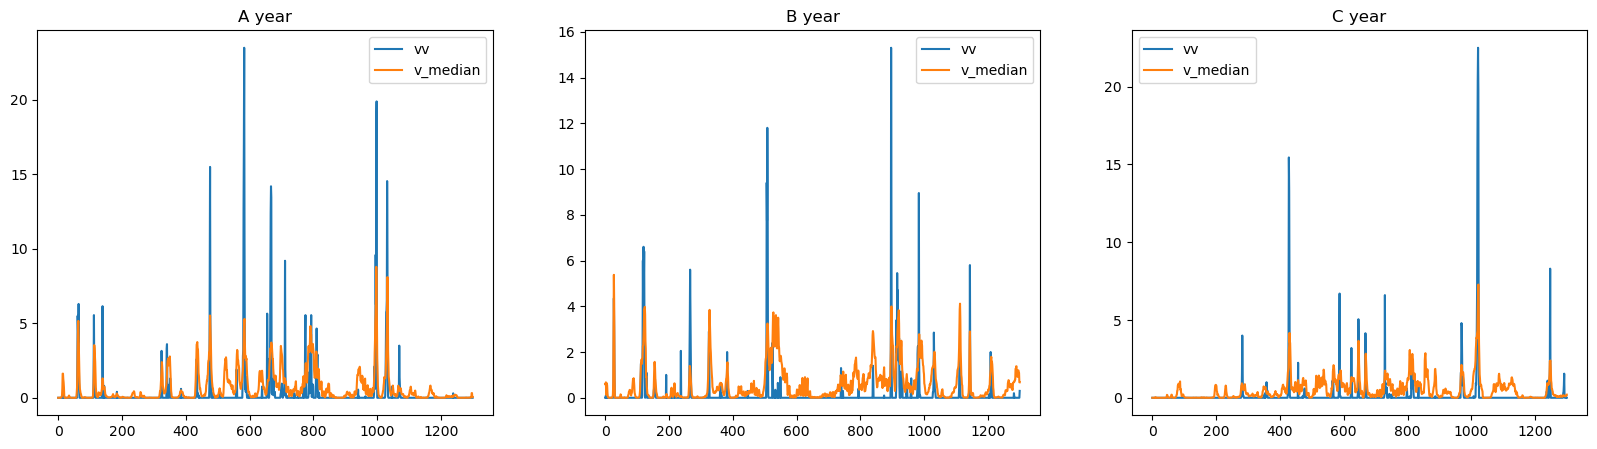

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,8))
fig, axes = plt.subplots(1,3)

fig.set_figheight(5)
fig.set_figwidth(20)

for idx, y in enumerate(train_df["rainfall_train.ef_year"].unique()):
    tmp_df = train_df[train_df["rainfall_train.ef_year"] == y]
    axes[idx].plot(tmp_df.groupby(by=["rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.ef_hour"])["rainfall_train.vv"].median().reset_index()["rainfall_train.vv"], label="vv")
    axes[idx].plot(tmp_df.groupby(by=["rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.ef_hour"])["v_median"].median().reset_index()["v_median"],label="v_median")
    axes[idx].set_title("{} year".format(y))
    axes[idx].legend()

### Voting을 활용한 argMax 모델 

**argMax 모델: 정확도**

In [6]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_score(train_df[["rainfall_train.v0{}".format(i) for i in range(10)]].apply(lambda x : x.argmax(),axis=1) == 0, train_df["rainfall_train.class_interval"] == 0)

0.8481103176367133

In [9]:
import numpy as np

train_df["flag"] = train_df[["rainfall_train.v0{}".format(i) for i in range(10)]].apply(lambda x: x.argmax() == 0, axis=1)
group_df = train_df.groupby(by=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.ef_hour"])
group_length = group_df["rainfall_train.vv"].apply(lambda x:len(x)).to_numpy()
group_result = group_df["flag"].sum().to_numpy()


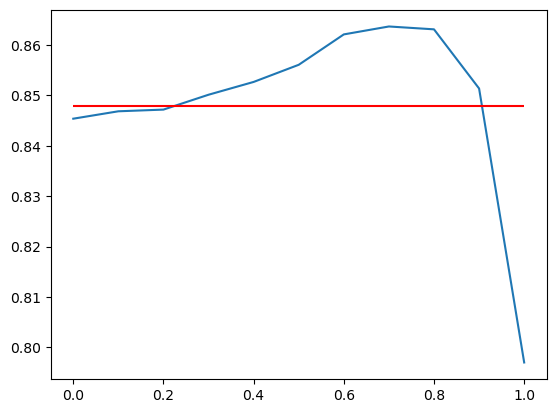

In [10]:

acc_list = []
f1_list = []
for i in range(11):
    f = 0.1 * i
    group_ans = ((group_result / group_length) >= f)
    right_df = group_df["flag"].mean().reset_index()
    right_df["flag"] = group_ans
    acc_list.append(accuracy_score(right_df["flag"], group_df["rainfall_train.class_interval"].mean() == 0))
    f1_list.append(f1_score(right_df["flag"], group_df["rainfall_train.class_interval"].mean() == 0))

plt.plot([0.1* i for i in range(11)], acc_list)
plt.hlines(0.848,0,1,colors="red")

### 랜덤 포레스트 모델

**전체 데이터 각각 추론**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
cols = ["rainfall_train.v0{}".format(i) for i in range(1,10)]
acc_dict = {}
for y in train_df["rainfall_train.ef_year"].unique():
    train_data = train_df[train_df["rainfall_train.ef_year"] !=y]
    test_data = train_df[train_df["rainfall_train.ef_year"] ==y]
    model = RandomForestClassifier(n_estimators=25)
    model.fit(train_data[cols],  train_data["rainfall_train.class_interval"] ==0)
    pred = model.predict(test_data[cols])
    acc_dict[y] = accuracy_score(pred,(test_data["rainfall_train.class_interval"]==0))
    # discover relations in datas
    
        

In [12]:
acc_dict

{'A': 0.8322021830035231, 'B': 0.8503073155531575, 'C': 0.867657891316055}

**보팅 알고리즘**

In [13]:
cols = ["rainfall_train.v0{}".format(i) for i in range(1,10)]
voting_acc_dict = {}
for y in train_df["rainfall_train.ef_year"].unique():
    train_data = train_df[train_df["rainfall_train.ef_year"] !=y]
    test_data = train_df[train_df["rainfall_train.ef_year"] ==y]

    # 학습
    model = RandomForestClassifier(n_estimators=25)
    model.fit(train_data[cols],  train_data["rainfall_train.class_interval"] ==0)

    # 추론
    test_data["pred"] = model.predict(test_data[cols])

    group = test_data.groupby(by=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.ef_hour"])

    _list = []
    for i in range(10):
        f = 0.1 * i
        _list.append(accuracy_score(group["pred"].mean().to_numpy() >= f , group["rainfall_train.class_interval"].median()==0))
    voting_acc_dict[y] = _list


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25480\1116708039.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["pred"] = model.predict(test_data[cols])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25480\1116708039.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["pred"] = model.predict(test_data[cols])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25480\1116708039.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Text(0.5, 1.0, 'C year')

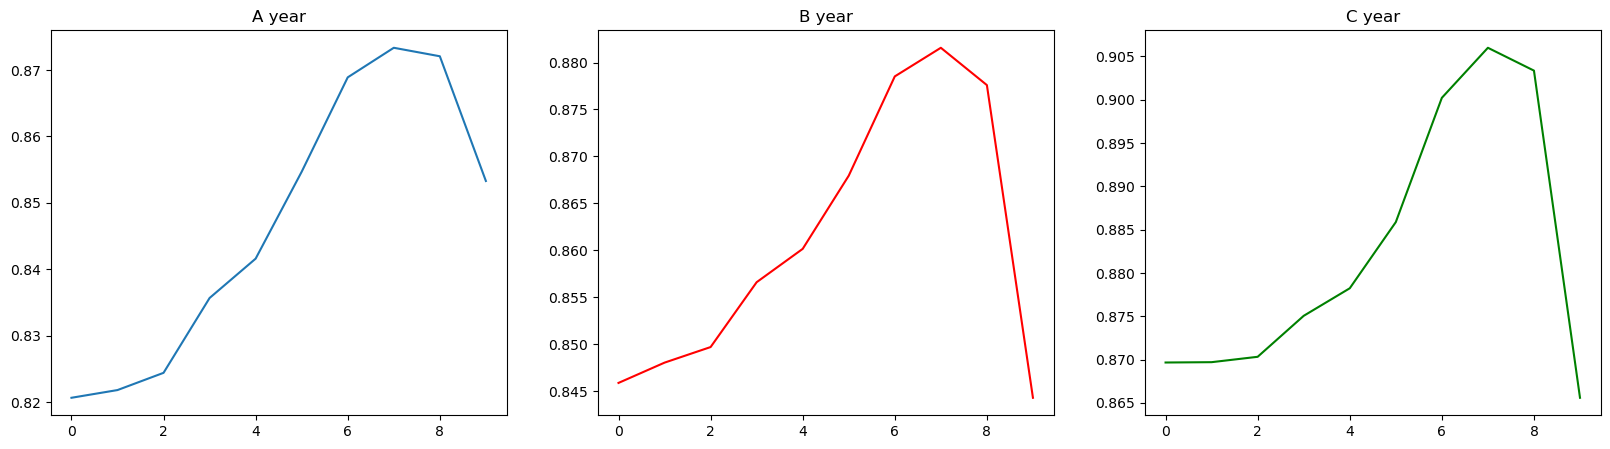

In [14]:
fig, axes = plt.subplots(1,3)

fig.set_figwidth(20)
fig.set_figheight(5)

axes[0].plot(voting_acc_dict["A"])
axes[0].set_title("A year")

axes[1].plot(voting_acc_dict["B"], color="red")
axes[1].set_title("B year")

axes[2].plot(voting_acc_dict["C"], color="green")
axes[2].set_title("C year")



## DNN 모델

### Binary Cross Entropy Loss function

In [22]:
import torch
from torch import nn

class Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=9, out_features=100)
        self.layer2 = nn.Linear(in_features=100, out_features=100)
        self.layer3 = nn.Linear(in_features=100, out_features=1)
    def forward(self,x):
        x = self.layer1(x)
        x = torch.sigmoid(x)
        x = self.layer2(x)
        x = torch.sigmoid(x)
        x = self.layer3(x)
        return x
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    return (correct / len(y_pred)) * 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Linear().to(device)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
epochs = 60
dnn_train_dict = {}
dnn_val_dict = {}
for y in train_df["rainfall_train.ef_year"].unique():
    
    # 훈련/검증 데이터
    train_data = train_df[train_df["rainfall_train.ef_year"] != y]
    test_data = train_df[train_df["rainfall_train.ef_year"] == y]

    x_train = torch.tensor(train_data[["rainfall_train.v0{}".format(i) for i in range(1,10)]].to_numpy().astype("float32")).to(device)
    x_test = torch.tensor(test_data[["rainfall_train.v0{}".format(i) for i in range(1,10)]].to_numpy().astype("float32")).to(device)

    y_train = torch.tensor((train_data["rainfall_train.class_interval"] == 0).to_numpy().astype("float32")).to(device)
    y_test = torch.tensor((test_data["rainfall_train.class_interval"]==0).to_numpy().astype("float32")).to(device)

    model = Linear().to(device)
    optim = torch.optim.Adam(params=model.parameters(), lr=0.01)


    print("--------------------------------------------------")
    train_list = []
    val_list = []

    for epoch in range(epochs):
        model.train()
        logits = model(x_train).squeeze()
        pred = torch.round(torch.sigmoid(logits))
        loss = loss_fn(logits,y_train)
        acc = acc_fn(y_train,pred)
        train_list.append(acc)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        model.eval()

        with torch.inference_mode():
            test_logits = model(x_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_loss = loss_fn(test_logits,y_test)
            test_acc = acc_fn(y_test,test_pred)
            val_list.append(test_acc)
            
        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | test loss: {test_loss:.5f} | test acc: {test_acc:.2f}%')
            
    dnn_train_dict[y] = train_list
    dnn_val_dict[y] = val_list

--------------------------------------------------
Epoch: 0 | Loss: 0.75496 | Acc: 14.00% | test loss: 0.49811 | test acc: 81.35%
Epoch: 10 | Loss: 0.37911 | Acc: 86.00% | test loss: 0.44743 | test acc: 81.35%
Epoch: 20 | Loss: 0.35542 | Acc: 86.00% | test loss: 0.40103 | test acc: 81.35%
Epoch: 30 | Loss: 0.33093 | Acc: 86.00% | test loss: 0.38743 | test acc: 81.35%
Epoch: 40 | Loss: 0.32178 | Acc: 86.00% | test loss: 0.36963 | test acc: 81.35%
Epoch: 50 | Loss: 0.31592 | Acc: 87.26% | test loss: 0.36084 | test acc: 83.54%
Epoch: 60 | Loss: 0.31188 | Acc: 87.55% | test loss: 0.35656 | test acc: 84.03%
Epoch: 70 | Loss: 0.30929 | Acc: 87.65% | test loss: 0.35564 | test acc: 84.16%
Epoch: 80 | Loss: 0.30761 | Acc: 87.70% | test loss: 0.35237 | test acc: 84.20%
Epoch: 90 | Loss: 0.30652 | Acc: 87.73% | test loss: 0.35140 | test acc: 84.22%
Epoch: 100 | Loss: 0.30577 | Acc: 87.74% | test loss: 0.35116 | test acc: 84.23%
Epoch: 110 | Loss: 0.30523 | Acc: 87.76% | test loss: 0.35049 | test 

**A,B,C년도 각각에 대한 결과**

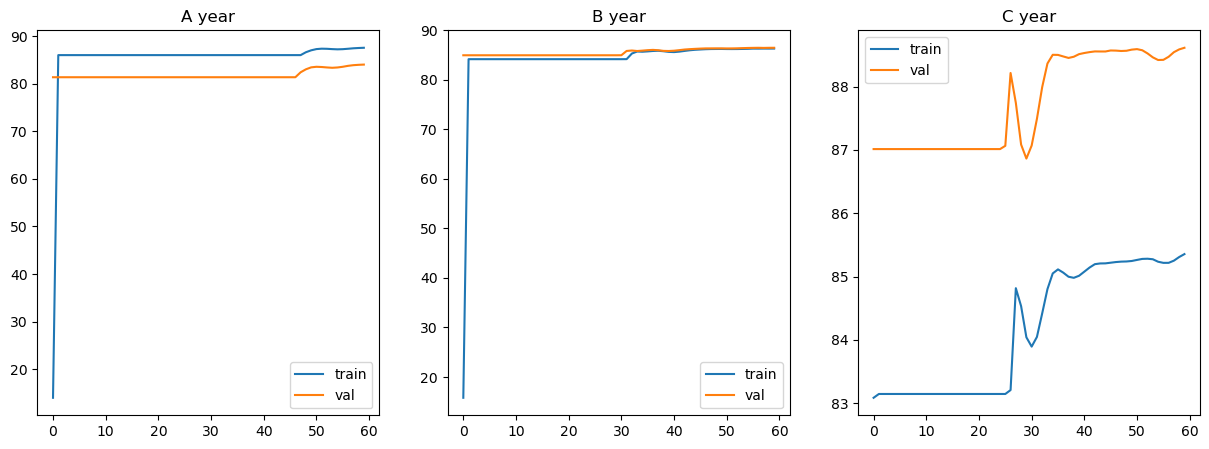

In [25]:
fig, axes = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(5)
axes[0].plot(dnn_train_dict["A"][:60],label="train")
axes[0].plot(dnn_val_dict["A"][:60],label="val")
axes[0].set_title("A year")
axes[0].legend()

axes[1].plot(dnn_train_dict["B"][:60],label="train")
axes[1].plot(dnn_val_dict["B"][:60],label="val")
axes[1].set_title("B year")
axes[1].legend()

axes[2].plot(dnn_train_dict["C"][:60],label="train")
axes[2].plot(dnn_val_dict["C"][:60],label="val")
axes[2].set_title("C year")
axes[2].legend()



In [29]:
print("A: {:.3f}, B: {:.3f}, C: {:.3f}".format(dnn_val_dict["A"][-1],dnn_val_dict["B"][-1],dnn_val_dict["C"][-1]))

A: 84.240, B: 86.695, C: 88.737


**보팅 알고리즘 사용**

In [23]:
from sklearn.metrics import accuracy_score

loss_fn = nn.BCEWithLogitsLoss().to(device)
epochs = 60
dnn_voting_dict = {}
for y in train_df["rainfall_train.ef_year"].unique():
    
    # 훈련/검증 데이터
    train_data = train_df[train_df["rainfall_train.ef_year"] != y]
    test_data = train_df[train_df["rainfall_train.ef_year"] == y]

    x_train = torch.tensor(train_data[["rainfall_train.v0{}".format(i) for i in range(1,10)]].to_numpy().astype("float32")).to(device)
    x_test = torch.tensor(test_data[["rainfall_train.v0{}".format(i) for i in range(1,10)]].to_numpy().astype("float32")).to(device)

    y_train = torch.tensor((train_data["rainfall_train.class_interval"] == 0).to_numpy().astype("float32")).to(device)
    y_test = torch.tensor((test_data["rainfall_train.class_interval"]==0).to_numpy().astype("float32")).to(device)

    model = Linear().to(device)
    optim = torch.optim.Adam(params=model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        logits = model(x_train).squeeze()
        pred = torch.round(torch.sigmoid(logits))
        loss = loss_fn(logits,y_train)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    model.eval()
    with torch.inference_mode():
        test_logits = model(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = acc_fn(y_test,test_pred)
            
    # 보팅 알고리즘
    test_data["flag"] = test_pred.cpu().numpy()
    group = test_data.groupby(by=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.ef_hour"])
    dnn_voting_dict[y] = accuracy_score(group["rainfall_train.class_interval"].median()==0,group["flag"].mean().to_numpy() >= 0.7)
            

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_46852\2206020663.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["flag"] = test_pred.cpu().numpy()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_46852\2206020663.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["flag"] = test_pred.cpu().numpy()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_46852\2206020663.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [24]:
dnn_voting_dict

{'A': 0.8693344696676222, 'B': 0.8765146252990661, 'C': 0.8996704787749564}

### 가장 빠른 DH 

In [ ]:
tmp = train_df.groupby(by=["rainfall_train.stn4contest", "rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.ef_hour"])["rainfall_train.dh"].min().reset_index()
tmp.columns = ["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.ef_hour","min_dh"]
tmp = pd.merge(train_df,tmp,how="left",on=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.ef_hour"])

### 랜덤 포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier

fast_dh_data = tmp[tmp["rainfall_train.dh"] == tmp["min_dh"]]
fast_acc_dict = {}
cols = ["rainfall_train.v0{}".format(i) for i in range(9)]
for y in fast_dh_data["rainfall_train.ef_year"].unique():
    train_data = fast_dh_data[fast_dh_data["rainfall_train.ef_year"] != y]
    test_data = fast_dh_data[fast_dh_data["rainfall_train.ef_year"] == y]

    model = RandomForestClassifier(n_estimators=25)
    model.fit(train_data[cols], train_data["rainfall_train.class_interval"])
    pred = model.predict(test_data[cols])
    fast_acc_dict[y] = accuracy_score(test_data["rainfall_train.class_interval"], pred)
    
    

In [ ]:
fast_acc_dict

### DNN

In [27]:
from sklearn.metrics import accuracy_score

loss_fn = nn.BCEWithLogitsLoss().to(device)
epochs = 60
dnn_fast_dict = {}
for y in train_df["rainfall_train.ef_year"].unique():
    
    # 훈련/검증 데이터
    train_data = train_df[train_df["rainfall_train.ef_year"] != y]
    test_data = tmp[tmp["rainfall_train.ef_year"] == y]

    x_train = torch.tensor(train_data[["rainfall_train.v0{}".format(i) for i in range(1,10)]].to_numpy().astype("float32")).to(device)
    x_test = torch.tensor(test_data[["rainfall_train.v0{}".format(i) for i in range(1,10)]].to_numpy().astype("float32")).to(device)

    y_train = torch.tensor((train_data["rainfall_train.class_interval"] == 0).to_numpy().astype("float32")).to(device)
    y_test = torch.tensor((test_data["rainfall_train.class_interval"]==0).to_numpy().astype("float32")).to(device)

    model = Linear().to(device)
    optim = torch.optim.Adam(params=model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        logits = model(x_train).squeeze()
        pred = torch.round(torch.sigmoid(logits))
        loss = loss_fn(logits,y_train)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    model.eval()
    with torch.inference_mode():
        test_logits = model(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = acc_fn(y_test,test_pred)
            
    # fast
    dnn_fast_dict[y]= accuracy_score(test_pred.cpu().numpy(),test_data["rainfall_train.class_interval"] ==0)
            

In [28]:
dnn_fast_dict

{'A': 0.8406950709558461, 'B': 0.8656072174715009, 'C': 0.884647366259984}